# Similarités entre séries

_ismael Bonneau & issam Benamara_

### Recommandation basée sur le contenu

_recherche d'une mesure de similarité pertinente, associée à une feature representation pertinente_


### Principe:

Une des façons de faire de la recommandation est de recommander des objets proches des objets aimés par un utilisateur donné. Ainsi, si un utilisateur a aimé fast & furious 5 6 & 7, un système de recommandation basé sur le contenu lui suggèrera de regarder the transporter avec Jason Statham, et d'autres films d'action incluant des voitures.

<img src="images/obelix.png" width="500">


le contenu de chaque item est représenté par un ensemble de descripteurs, qui peuvent être de nature différente: bag of words, ensemble de caractéristiques numériques, catégorie, casting...

Il faut alors trouver une façon de calculer une similarité entre ces représentations, et donc ces items, de sorte à ce que deux items propres réellement soient séparés par une mesure de similarité forte (= distance faible).

-------------------------------

### Notre but:

-------------------------------
Construire une **mesure de similarité** pour recommander des séries en se basant sur le contenu. On se basera ici sur des descripteurs à base de sous-titres, de texte donc.

### Méthode d'évaluation:

-------------------------------
Ici, la difficulté réside dans l'évaluation: comment savoir si une mesure d'évaluation est meilleure qu'une autre? Pas de RMSE ici, pas de MAE, aucune métrique exacte, nous devons bricoler et créer notre propre mesure de qualité. Nous pourrons utiliser des mesures issues de la RI comme la précision, le rappel, le score F1, la <a href="https://en.wikipedia.org/wiki/Discounted_cumulative_gain">NDCG</a>, nous y reviendrons plus tard. En calculant des clusters sur ces distances une fois calculées, nous pourrions aussi utiliser des mesures de qualité qui proviennent du clustering. Nous pouvons aussi aller plus loin et créer des mesures de qualité plus poussées.

Dans tous les cas, nous nous appuirons sur le **genre** des séries pour évaluer la qualité des mesures de similarité. Pour chaque série, nous connaissons son/ses genres (action, aventure, comédie...). Nous considérerons (mais cela est contestable) qu'un bon système de recommandation basé sur le contenu doit au moins recommander des séries du même genre ou qui partagent ne nombreux "sous genres" en commun. Par exemple, Pour "les Simpsons", le système devra considérer avant tout des séries comiques d'animation.

### Données:

Nous partons d'une base de 3369 séries tv. Ces séries contiennent chacune une seule ou plusieurs saisons, qui contiennent un seul ou plusieurs épisodes. Ces épisodes sont représentés par leurs **sous-titres** en anglais. Les mesures de similarité entre séries se baseront donc sur leurs **sous-titres**.

In [4]:
import glob
import re
import numpy as np
import gensim 
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import seaborn as sns
#using https://github.com/amueller/word_cloud
from wordcloud import WordCloud

from sklearn.manifold import TSNE

from utils.load_data import getMostImportantSeries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import random
import collections

plt.style.use('seaborn-white')
%matplotlib inline

#dataset path
path = "dataset"

In [5]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_short, remove_stopwords
from gensim.parsing.preprocessing import strip_numeric, strip_non_alphanum, strip_multiple_whitespaces

import random

CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_short,
                  strip_numeric, strip_non_alphanum, remove_stopwords]

#fonction pour doc2vec gensim
def read_corpus(flist, test_size=0.2, split=True):
    train = []
    test = []
    if not split:
        for i, serie in enumerate(flist):
            episodes = ""
            listepisodes = glob.glob(path+"/"+serie+"/*/*.lines")
            if len(listepisodes) > 30:
                random.shuffle(listepisodes)
                listepisodes = listepisodes[:30]
            for episode in listepisodes:
                with open(episode, "r", encoding="utf-8") as file:
                    episodes += " " + file.read()
            train.append(gensim.models.doc2vec.TaggedDocument(preprocess_string(episodes, CUSTOM_FILTERS), tags=[i]))
        return train
    for i, serie in enumerate(flist):
        listepisodes = glob.glob(path+"/"+serie+"/*/*.lines")
        if len(listepisodes) > 30:
            random.shuffle(listepisodes)
            listepisodes = listepisodes[:30]
        tokens_train = ""
        tokens_test = ""
        for episode in listepisodes:
            with open(episode, "r", encoding="utf-8") as file:
                if random.random() < test_size:
                    tokens_test += " " + file.read()
                else:
                    tokens_train += " " + file.read()
        train.append(gensim.models.doc2vec.TaggedDocument(preprocess_string(tokens_train, CUSTOM_FILTERS), tags=[i]))
        test.append(gensim.models.doc2vec.TaggedDocument(preprocess_string(tokens_test, CUSTOM_FILTERS), tags=[i]))
    return train, test

In [6]:
#pour rendre le notebook plus clean!
def printMatrice(sim, series):
    plt.figure(figsize=(10,10))
    plt.imshow(sim, cmap='YlGn', interpolation='nearest')
    plt.xticks(range(len(series)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
    plt.yticks(range(len(series)), [" ".join(x.split("_")[1:]) for x in series])
    plt.show()
def krecommendations(sim, series, serie, k):
    print("series les plus proches de {}:".format(" ".join(serie.split("_")[1:])))
    mdr = [(series[i], a) for i, a in enumerate(sim[series.index(serie)])]
    for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:k]]:
        print("  ", " ".join(b))

Reprenons notre liste de séries célèbres, étoffée cette fois-ci: la liste contient **51 séries de plusieurs genres différents**, triés de manière à former des "blocs" de séries du même genre.

In [4]:
series = ['1910_NCIS','2733_NCIS__Los_Angeles','2639_NCIS__New_Orleans', '2956_Criminal_Minds', '1041_CSI_Crime_Scene_Investigation',
 '1830_CSI_Miami', '207_Bones', '2212_The_Mentalist', '2767_The_Blacklist', '413_Dexter', '1845_Sherlock_(2010)',
 '884_The_X-Files', '3259_Stargate_SG-1', "1867_Stargate_Atlantis", '381_Star_Trek_The_Next_Generation', '2120_Doctor_Who_(1963)',
 '2091_Star_Trek_Deep_Space_Nine', '384_Twilight_Zone', '186_Doctor_Who', '1704_Rick_and_Morty',
 '2469_The_Simpsons', "1495_Futurama", '2556_The_Big_Bang_Theory', '292_Modern_Family', '1718_South_Park', '95_How_I_Met_Your_Mother',
 '3012_Greys_Anatomy', '2261_Buffy_The_Vampire_Slayer', '175_The_Walking_Dead', '1262_Lost', '1039_Narcos',
 '818_Gomorra_(2014)', '2123_Sense8', '3280_Peaky_Blinders', '121_Suits', '76_Breaking_Bad', '217_Game_of_Thrones',
 '2567_House', '1701_Outlander', '2936_Desperate_Housewives', '2053_Charmed', '345_Dallas', '1641_Pretty_Little_Liars',
 '3314_Shameless', '25_Friends','1906_The_Vampire_Diaries', '196_Smallville', "1589_Teen_Titans", "2546_Teenage_Mutant_Ninja_Turtles_(2012)",
         "223_X-Men", "1474_The_Batman"]
print(len(series))

51


In [7]:
series_toid = {series[i]: i for i in range(len(series))}

In [5]:
corpus = []
for serie in series_df["seriesname"]:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.lines")
    if len(listepisodes) > 30:
        random.shuffle(listepisodes)
        listepisodes = listepisodes[:30]
    text = ""
    for episode in listepisodes:
        with open(episode, "r", encoding="utf-8") as file:
            text += " " + " ".join(preprocess_string(file.read(), CUSTOM_FILTERS))
    corpus.append(text)
print(len(corpus))

51


### Matrice de similarité:

Pour indiquer la ressemblance entre deux séries, nous allons construire une matrice de similarité. Une matrice de similarité de ${n}$ éléments est tout simplement une matrice ${M}$ de dimension ${n\times n}$ ou l'élément ${M_{i,j}}$ indique la similarité entre l'élément numéro ${i}$ et l'élément numéro ${j}$. Une telle matrice est une représentation graphique agréable, mais peut devenir lourde à maintenir en mémoire quand ${n}$ devient grand.

ci-dessous, un exemple de matrice de similarité avec ${n = 4}$ entre les items A, B, C, D. La diagonale remplie de 1 correspond au fait que chaque élément est identique à lui même, donc totalement similaire.

<img src="images/simmatrix.png" width="200" />

#### ... avec une mesure de similarité:

Une mesure de similarité très adaptée au cas des vecteurs sparse est le produit cosinus, ou similarité cosinus.

<img src="images/cosinesim.png" width="400" />

La similarité cosinus de deux vecteurs est simplement leur produit scalaire, divisé par le produit de leurs normes (il existe aussi une version sans division par le produit des normes). Il s'agit d'une mesure de similarité très appropriée aux vecteurs contenant beaucoup de valeurs nulles ("sparse"), et convient donc ici particulièrement.
Elle correspond en fait au cosinus de l'angle formé par les deux vecteurs: si les deux vecteurs sont très similaires, l'angle qu'ils forment aura un cosinus proche de 1 car ${\cos{0} = 1}$. Dans le cas où les deux vecteurs sont sans relation, c'est à dire orthogonaux, leur angle sera proche de 90 degrés et son cosinus vaudra 0. Enfin, si les deux vecteurs sont similaires mais opposés, l'angle qu'il forment sera proche de 180 degrés et son cosinus tendra vers -1.

<img src="images/cosinesimilarityfq1.png"/>

#### ... Sur quelles données?

Reste à choisir comment représenter les séries. Ici, pour **commencer**, notre représentation sera faite à partir de vecteurs bag-of-words (sac de mots). La représentation bag of words est est une représentation dans laquelle on considère un dictionnaire de mots (ensemble de mots) qui peuvent servir à représenter n'importe quel document. Un document est alors représenté par un vecteur de la même taille que le dictionnaire, où la composante ${i}$ de ce vecteur correspond au nombre d'occurence du ${i}$ème mot du dictionnaire.

Par exemple, avec la phrase "the dog is on the table" et le dictionnaire {"are", "cat", "dog", "is", "now", "on", "table", "the"}:

<img src="images/bow.png" width="300" />

Par ailleurs, le texte est lemmatisé au préalable: cela signifie que tous les mots sont mis sous une forme standard, sans flexion. Il n'y a donc plus de pluriel, plus de temps grammatical, de participe passé... cela constitue un prétraitement efficace pour réduire la taille du dictionnaire.

exemple:

| **mot**      |     **lemme**    |
| ------------- |: -------------: |
| happy, happiness, happy      |        happy       |
|   playing, played, plays      |        play        |
| am, are, is      |        be        |

Un **dernier détail**: on règle le _DF_, c'est à dire le _document frequency_, à 2 afin de ne pas garder de mots particuliers à une série.

### Vecteur de DF:

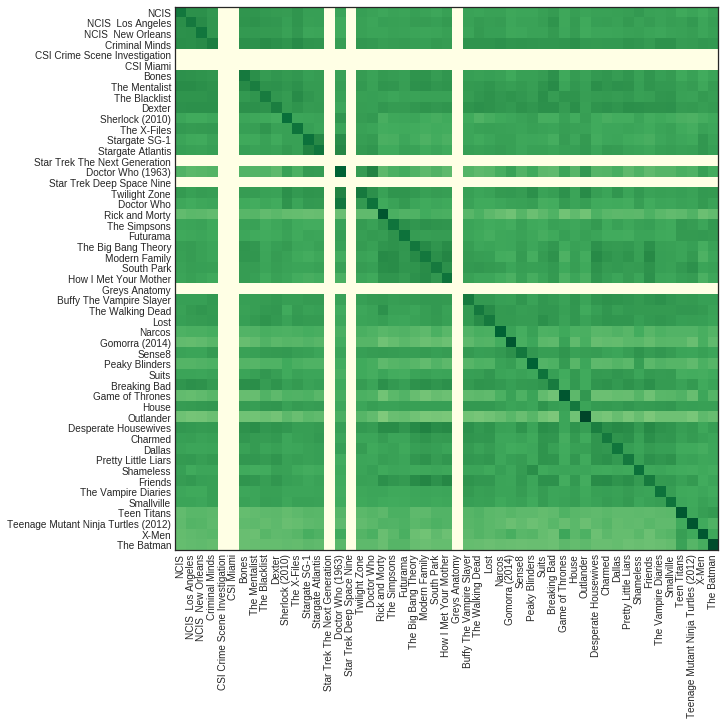

In [56]:
counter_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', min_df=2)
x = counter_vect.fit(corpus)
vec = counter_vect.transform(corpus)
sim = cosine_similarity(vec)
sim = normalize(sim, norm='l1', axis=0)
printMatrice(sim, series)

In [51]:
krecommendations(sim, series, '2956_Criminal_Minds', 5)
krecommendations(sim, series, '1474_The_Batman', 5)
krecommendations(sim, series, '2469_The_Simpsons', 5)
krecommendations(sim, series, '381_Star_Trek_The_Next_Generation', 5)

series les plus proches de Criminal Minds:
   Criminal Minds
   NCIS  New Orleans
   The X-Files
   The Blacklist
   NCIS
series les plus proches de The Batman:
   The Batman
   Teen Titans
   X-Men
   The Simpsons
   Teenage Mutant Ninja Turtles (2012)
series les plus proches de The Simpsons:
   The Simpsons
   Futurama
   Modern Family
   South Park
   How I Met Your Mother
series les plus proches de Star Trek The Next Generation:
   NCIS  Los Angeles
   NCIS  New Orleans
   Criminal Minds
   CSI Crime Scene Investigation
   NCIS


#### Résultat:

Ce modèle parait également à première vue très bon, du moins pour les 5-6 premières recommendations. Il se trompe en revanche totalement pour la science-fiction et confond les séries policières et la SF... pas top!

Essayons l'approche vecteur de tf-idf, en réglant le DF minimum afin de retirer du corpus les mots trop particuliers à une série, en vue d'étudier son impact sur la similarité:

### Vecteur de TF-IDF:

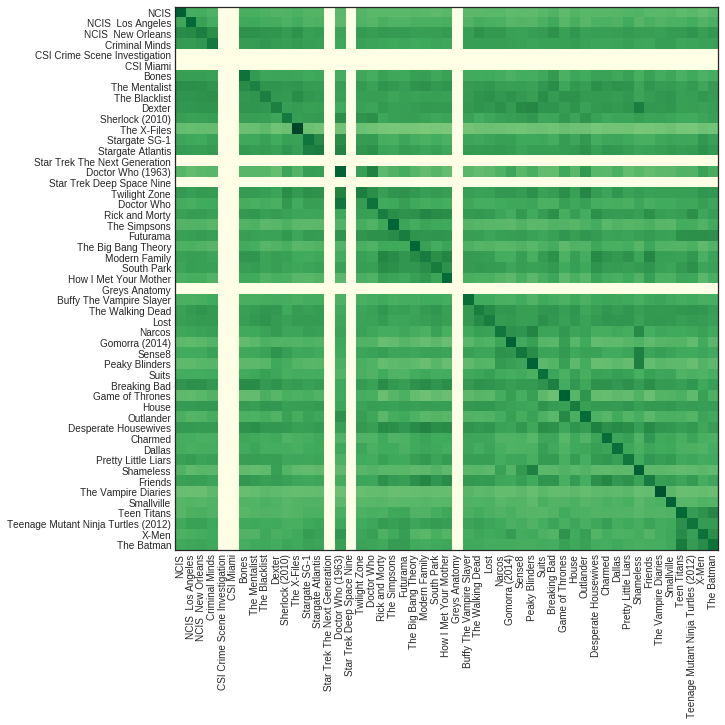

In [57]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=1000, min_df=2)
x = tfidf_vect.fit(corpus)
vec = tfidf_vect.transform(corpus)
sim = cosine_similarity(vec)
sim = normalize(sim, norm='l1', axis=0)

printMatrice(sim, series)

In [53]:
krecommendations(sim, series, '2956_Criminal_Minds', 5)
krecommendations(sim, series, '1474_The_Batman', 5)
krecommendations(sim, series, '2469_The_Simpsons', 5)
krecommendations(sim, series, '381_Star_Trek_The_Next_Generation', 5)

series les plus proches de Criminal Minds:
   Criminal Minds
   NCIS  New Orleans
   The Blacklist
   The X-Files
   NCIS
series les plus proches de The Batman:
   The Batman
   Teen Titans
   X-Men
   Teenage Mutant Ninja Turtles (2012)
   Futurama
series les plus proches de The Simpsons:
   The Simpsons
   Modern Family
   Futurama
   Rick and Morty
   South Park
series les plus proches de Star Trek The Next Generation:
   NCIS  Los Angeles
   NCIS  New Orleans
   Criminal Minds
   CSI Crime Scene Investigation
   NCIS


#### Résultat:

Premièrement, les similarités ont l'air meilleures pour les simpsons: le système recommande maintenant modern family, rick et morty, south park...

On remarque la présence d'un carré assez sombre en haut à gauche: le modèle a reconnu une certaine similarité entre les séries de type "policier" comme esprits criminels, ou NCIS. Un autre "carré" est aussi présent dans l'image, qui correspond à une certaine similarité entre les séries dites "comiques" comme les simpsons, modern family, south park... un bloc "science-fiction" est aussi présent.

On remarque que le modèle devient mauvais à partir de la 5e recommendation environ: la base de test est trop petite pour permettre de recommender autant de séries.

Etant donné la proximité des résultats des 2 modèles, un problème se pose:

>Comment évaluer la qualité d'un modèle de similarité?

Nous devons utiliser une ou plusieurs mesures de similarité pour évaluer qualitativement nos modèles, afin d'être en mesure de choisir le meilleur.

Nous **reviendrons plus tard** sur les mesures de qualité. Passons à la similarité à l'aide d'embeddings:

Sur cet exemple sur la série "Les Simpsons", on voit que le système a recommendé plusieurs séries dont le genre n'a rien à voir avec les simpsons: American Horror Story, MacGyver (MacGyver ressemble aux simpsons, vraiment?!), Lost girl, Voyagers, Desperate housewifes...

In [50]:
#classe implémentant les mesures de rappel/précision/score F1
from utils.evalIRmodel import EvalIRmodel

In [52]:
warnings.filterwarnings(action='once')

similairesTFIDF = []

for s in range(len(series)):
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    similairesTFIDF.append([a for a, b in mdr])

evaluation = EvalIRmodel()

pertinent, skippable = evaluation.buildPertinents(series_df)
evaluations = evaluation.evaluate(similairesTFIDF, pertinent, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

precision: 0.782
rappel: 0.027
F1: 0.032


Avec un modèle à base de bag of words:

In [53]:
counter_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
x = counter_vect.fit(corpus)
vec = counter_vect.transform(corpus)

sim = cosine_similarity(vec)
sim = normalize(sim, norm='l1', axis=0)

similairesBOW = []

for s in range(len(series)):
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    similairesBOW.append([a for a, b in mdr])

evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similairesBOW, pertinent, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

/root/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


precision: 0.717
rappel: 0.029
F1: 0.035


# Approche Embeddings

Un embedding est une façon de représenter (encoder) des objets par des vecteurs d'une taille définie, ${p}$ ici.

## Similarités entre séries par document Embeddings 

Pour des exemples d'utilisation plus détaillés de gensim doc2vec, nous vous renvoyons à leur site: et à ce <a href='https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb'>notebook</a>.

Dans ce qui suit nous utiliserons le terme "Document" pour désigner une série. On considère une série comme la concaténation de tous les sous titres de tous ses épisodes, et donc comme un long (très long) document.

Nous allons chercher à représenter les relations de **sémantique** entre les séries, c'est à dire rapprocher les séries qui **"parlent du même sujet"**.

### document embeddings

Doc2vec est une adaptation aux documents de word2vec. Il s'agit d'un modèle qui calcule des embeddings de documents, c'est à dire des représentations numériques d'un ensemble de documents dans un espace de taille ${p}$ fixe. Il prend en entrée un corpus de ${D}$ documents munis chacun d'un ID unique et renvoie après une phase de training une matrice de taille ${D, p}$ contenant les embeddings de chaque document.

.

<img src="images/word2vec_vs_doc2vec.png" width="700">

Le modèle fonctionne en apprenant un modèle word2vec de dimension ${p}$ sur les documents du corpus (un vecteur par mot du corpus, donc) et en répercutant en même temps cet apprentissage sur une représentation de dimension ${p}$ des documents du corpus, afin d'obtenir une représentation des mots et des documents liée, et donc **une représentation des documents porteuse de "contexte"**. 

On obtient donc 2 représentations, une pour les mots, une pour les documents, et se sert de l'apprentissage de la représentation des mots pour calculer une représentation des documents, la seule à nous être utile à la fin (ou pas?).

### Et... pourquoi doc2vec?

En apprenant une représentation pour les documents qui soit porteuse de sens d'un point de vue du contenu du document, on espère obtenir une meilleure représentation des séries tv qu'avec un modèle bag of words, vide de contexte. Sur ces représentations vectorielles, on pourra alors calculer des similarités entre séries, en utilisant par exemple la bonne vieille méthode de la similarité cosinus (plus performante que la distance euclidienne).

### Allons-y:

In [50]:
series, count = getMostImportantSeries(path)

series_toid = {series[i]: i for i in range(len(series))}
id_toserie = {series_toid[i]: i for i in series_toid.keys()}

Larger windows tend to capture more topic/domain information: what other words (of any type) are used in related discussions? Smaller windows tend to capture more about word itself: what other words are functionally similar? (Their own extension, the dependency-based embeddings, seems best at finding most-similar words, synonyms or obvious-alternatives that could drop-in as replacements of the origin word.)

In [ ]:
train_corpus = read_corpus(series, split=False)

In [ ]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=70, window=10, min_count=5, epochs=40, dm=1)
model.build_vocab(train_corpus)

#entrainement du modèle!
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

Charger le modèle pré-calculé pour plus de rapidité

In [51]:
model = gensim.models.doc2vec.Doc2Vec.load("doc2vec_model1")

In [10]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    
    second_ranks.append(sims[1])
    
ranks_ = collections.Counter(ranks)
print("{0:.2f}% des documents sont similaires à eux-mêmes en train.".format((ranks_[0]/len(train_corpus))*100))

99.90% des documents sont similaires à eux-mêmes en train.


#### Regardons quelles séries sont les plus similaires à quelques séries sympathiques:

In [28]:
def recommander(serie):
    inferred_vector = model.docvecs[series_toid[serie]]
    sims = model.docvecs.most_similar([inferred_vector], topn=5)
    print("\npour "+" ".join(serie.split("_")[1:])+":\n")
    for id_, sim in sims:
        print(" ".join(series[id_].split("_")[1:]))

recommander("292_Modern_Family")
recommander("3259_Stargate_SG-1")
recommander("207_Bones")
recommander("2469_The_Simpsons")
recommander("1704_Rick_and_Morty")


pour Modern Family:

Modern Family
Life in Pieces
I Hate My Teenage Daughter
Welcome To The Family
Happy Endings

pour Stargate SG-1:

Stargate SG-1
Stargate Atlantis
Stargate Universe
Star Trek  Enterprise
Crusade

pour Bones:

Bones
CSI  Crime Scene Investigation
NCIS
NCIS  New Orleans
Working Class

pour The Simpsons:

The Simpsons
Napoleon Dynamite
Clerks
Family Matters
Duckman

pour Rick and Morty:

Rick and Morty
Triptank
Robot Chicken
The Meltdown with Jonah and Kumail
Comedy Bang  Bang 


Plutôt bon! les séries "recommandées" correspondent vraiment à ce qu'on attendrait à première vue. Pour "les simpsons", les résultats sont suprenants, mais logiques. Pour "Rick et morty", les séries les plus proches sont toutes des comédies pour adultes, comme attendu.

#### On peut également regarder les embeddings des mots appris par word2vec en même temps:

In [6]:
result = model.wv.similar_by_word("batman")
for a,b in result:
    print(a)

robin
definitly
hood
batmobile
strach
joker
darkwing
paisa
superman
hitchcock


In [51]:
result = model.wv.similar_by_word("thor")
for a,b in result:
    print(a)

warrior
mjolnir
midgard
bonecrusher
shield
eurystheus
shiva
odin
gundersen
loki


In [11]:
result = model.wv.similar_by_word("superman")
for a,b in result:
    print(a)

superhero
kryptonite
myslel
cel
elastigirl
gosalyn
bizarro
superwoman
canaveral
cels


#### Résultat: 

Batman est proche de batmobile, de robin, de gotham, de superhero et caped, du joker... c'est parfait.
Thor est proche de son marteau Mjollnir, de Odin, loki, warrior et de midgard. Parfait là aussi.
Moins bon pour Superman, mais quand même bon: superhero, kryptonite, superwoman sont voisins.

In [6]:
embeddings = np.array([model.docvecs[i] for i in range(len(series))])

In [100]:
#sauvegarde des embeddings appris pour les visualiser dans tensorboard
np.savetxt(f"doc2vec.tsv", embeddings, delimiter="\t")
with open(f"doc2vec_metadata.tsv","w") as metadata_file:
    for x in series: #hack for space
        x = " ".join(x.split("_")[1:])
        if len(x.strip()) == 0:
            x = f"space-{len(x)}"
        metadata_file.write(f"{x}\n")

### Visualisation des Embeddings avec T-SNE

Nous allons visualiser les embeddings obtenus avec doc2vec en utilisant T-SNE. T-SNE est un algorithme de réduction de dimension très utile quand on veut visualiser des données initialement en grande dimension, en 2D ou 3D. Dans notre cas, nous allons l'utiliser pour passer de 70 dimensions à 2.

T-SNE est un algorithme itératif et probabiliste. Pour en savoir plus sur son fonctionnement: <a href="https://www.youtube.com/watch?v=NEaUSP4YerM">une petite vidéo</a>. Il est disponible en ligne sur le site de <a href="https://projector.tensorflow.org/">tensorflow projector</a> pour l'appliquer sur des données et visualiser le résultat directement.

In [9]:
series_df = pd.read_csv("series.csv") #on va récupérer les genres de chaque série pour la visualisation

In [12]:
#couleurs associées aux genres:
colors = ["lime","blue", "yellow", "hotpink", "red", "olive", "green", "black", "deekskyblue"]
#genres à considérer:
genres = ["Science-Fiction","Comedy","Adventure","Romance","Action","Documentary","Thriller","Drama"]

In [13]:
def getGenre(string):
    if type(string) != str:
        return ""
    for substring in genres: 
        if substring in string: 
            return substring
    return ""

In [14]:
ahaaa = {}
lescouleursdict = {}
for i, row in series_df.iterrows():
    if getGenre(row["genres"]) != "":
        genre = getGenre(row["genres"])
        ahaaa[row["seriesname"]] = genre
        lescouleursdict[row["seriesname"]] = colors[genres.index(genre)]

In [21]:
#on ne garde que les embeddings des séries dont on connait le genre
matrix = []
lescouleurs = []
lesgenres = []
for i in id_toserie:
    if id_toserie[i] in ahaaa:
        matrix.append(embeddings[i])
        lescouleurs.append(lescouleursdict[id_toserie[i]])
        lesgenres.append(ahaaa[id_toserie[i]])

In [22]:
#préparons TSNE
tsne = TSNE(n_components = 2, perplexity=10, learning_rate=100, n_iter=3000)
matrix_2d = tsne.fit_transform(matrix)

In [13]:
import matplotlib.patches as mpatches
#sert pour légender le scatter plot
patches = [mpatches.Patch(color=colors[i], label=genres[i]) for i in range(len(genres))]

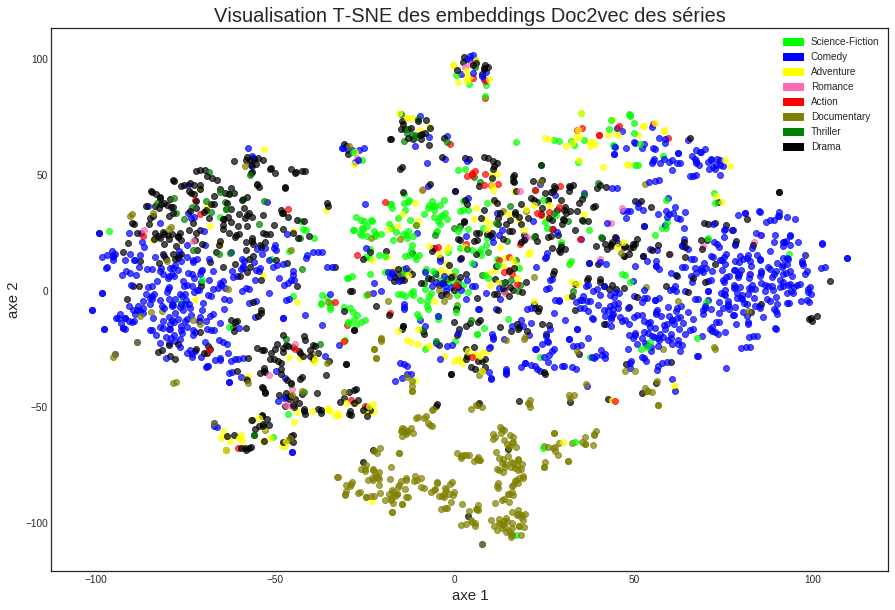

In [24]:
plt.figure(figsize=(15,10))
plt.title("Visualisation T-SNE des embeddings Doc2vec des séries", fontsize=20)
plt.xlabel("axe 1", fontsize=15)
plt.ylabel("axe 2", fontsize=15) #so meaningful wow
for i in range(len(matrix)):
    plt.scatter(matrix_2d[i, 0], matrix_2d[i, 1], alpha=0.7, c=lescouleurs[i]) #lent mais nécessaire
plt.legend(handles=patches)
plt.savefig("images/tsne_doc2vec.png")
plt.show()

### Pas terrible!

... Mais pas mal si on se rappelle des défauts dont souffre cette visualisation: Il y a plusieurs genres par série, et pour la visualisation nous avons du en choisir un seul... Les résultats sont donc à interpréter moins rigoureusement pour cette visualisation. Il sera impossible de voir un paquet clair de drama, de comedy car ces genres sont présent avec d'autres genres, surtout Drama. Il y a des comedy drama, des action drama, des romance drama...

C'est justement ce que traduit ce scatter plot! les documentaires forment un genre vraiment à part. On constate ensuite qu'il y a une zone science-fiction plutôt nette au centre. L'action est très peu mêlée à la comédie: c'est plutôt le drame (en noir). On peut aussi remarquer que les thriller sont toujours très proches des drames. D'une manière générale, les drames sont très dispersés car de nombreuses séries d'action, de SF, de romance, d'aventure etc ont une dimension "drame".

On peut néanmoins remarquer un "paquet" Documentaires... Les genres particuliers, qui ne sont généralement pas présents avec un autre genre. Les science-fiction se répartissent toutes aussi dans une même zone.

### Comment évaluer ces mesures de similarité?

Il n'existe aucune "vraie" façon de mesurer parfaitement la qualité de notre mesure de similarité. Néanmoins, Il nous faut un ensemble de mesures pour pouvoir comparer les recommandations les unes par rapport aux autres.

Dans un premier temps, nous évaluons les performances d'une recommendation en calculant une moyenne de ses scores de rappel, précision, et mesure F1. Une façon de définir les "séries pertinentes" que le système devrait théoriquement prédire est de se baser sur le genre des séries.

L'ensemble de métriques précision/rappel/F1 fournit une mesure pertinente: la **précision**. En mesurant la précision, nous évaluons la probabilité **qu'une série recommendée soit une série du même genre**.
Le **rappel**, quant à lui, mesure la probabilité **qu'une série du même genre soit recommendée**.

Le score F1, quant à lui, est la moyenne géométrique de la précision et du rappel (recall):

<img src="images/f1-score.jpg" width="250"/>

Nous chercherons à évaluer les performances de nos modèles en considérant comme référence à recommender les **séries du même genre**. Nous prendrons deux références pour une série A: 
- les séries qui ont tous les genres de A: par exemple, si A est du genre action-aventure, nous considérons les séries qui appartiennent toutes au genre action-aventure.
- les séries qui ont un genre en commun avec A: par exemple, si A est du genre action-aventure, toutes les séries qui sont soit action, soit aventure.

#### Les genres des séries nous sont donnés par l'api TVdb:

In [10]:
series_df.head()

,seriesname,id,imdbId,zap2itId,genres
0,2120_Doctor_Who_(1963),76107.0,tt0056751,EP001301,Action-Adventure-Science-Fiction
1,2469_The_Simpsons,71663.0,tt0096697,EP00018693,Animation-Comedy
2,1865_Law_Order_SVU,75692.0,tt0203259,EP00316978,Crime-Drama
3,779_Law_Order,91651.0,tt0405564,NaN,Drama-Mini-Series
4,1041_CSI_Crime_Scene_Investigation,72546.0,tt0247082,EP00380341,Crime-Drama


> **une autre idée:** mesurer, pour ${k}$ recommandations données pour une série A, le nombre de moyen de genres en commun entre la série A et les séries recommandées.

Par exemple, pour les séries proches de les simpsons, en utilisant la similarité donnée par les embeddings:

In [47]:
serie = "2469_The_Simpsons"

inferred_vector = model.docvecs[series_toid[serie]]
sims = model.docvecs.most_similar([inferred_vector], topn=7)
print("\npour "+" ".join(serie.split("_")[1:])+":\n")

genreserie = set(list(series_df[series_df["seriesname"] == serie]['genres'])[0].split("-"))
lol = []
for id_, sim in sims:
    genres = list(series_df[series_df["seriesname"] == id_toserie[id_]]['genres'])
    if len(genres) < 1:
        genres = ["unknown"]
    else:
        inter = len(set(genres[0].split("-")) & genreserie)
    lol.append(inter)
    print(" ".join(series[id_].split("_")[1:]), "genre:", genres[0], inter, " genres en commun")
    
print("\nen moyenne: ", round(np.mean(lol),2), " en commun sur ", len(genreserie))


pour The Simpsons:

The Simpsons genre: Animation-Comedy 2  genres en commun
Napoleon Dynamite genre: Animation-Comedy 2  genres en commun
The Critic genre: Animation-Comedy 2  genres en commun
Duckman genre: Animation-Comedy 2  genres en commun
The Lone Gunmen genre: Drama-Science-Fiction-Thriller 0  genres en commun
The Cleveland Show genre: Animation-Comedy 2  genres en commun
Boy Meets World genre: Children-Comedy-Drama 1  genres en commun

en moyenne:  1.57  en commun sur  2


On voit que 6 des 7 premières séries recommandées sont des comédies et 5 des dessins animés également.

chargeons la matrice de similarité de 2996 séries calculée sur des vecteurs de TF-IDF, puis évaluons les performances: On va comparer vecteurs de tf-idf et embeddings doc2vec

In [18]:
id_toserie = {}
for i, serie in enumerate(series_df["seriesname"]):
    id_toserie[i] = serie

In [15]:
sim = np.load("sim.npy")

In [39]:
genres = {}
for idx, row in series_df.iterrows():
    if type(row["genres"]) != float:
        genres[row["seriesname"]] = row["genres"]

In [45]:
kmesures = []
for k in range(3, 20, 1):
    mesures = []
    for i in range(len(sim)):
        if id_toserie[i] in genres:
            genreserie = set(genres[id_toserie[i]].split("-"))
            mdr = [(id_toserie[j], a) for j, a in enumerate(sim[i])]
            lol = []
            for a in [a for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[1:k+1]]:
                if a in genres:
                    inter = len(set(genres[a].split("-")) & genreserie)
                    lol.append(inter / len(genreserie))
            mesures.append(np.mean(lol))
    kmesures.append(np.mean(mesures))

In [64]:
kmesuresembedding = []
for k in range(3, 20, 1):
    mesuresembedding = []
    for serie in series_toid:
        if serie in genres:
            inferred_vector = model.docvecs[series_toid[serie]]
            sims = model.docvecs.most_similar([inferred_vector], topn=k)

            genreserie = set(genres[serie].split("-"))
            lol = []
            for id_, sim in sims:
                if id_toserie[id_] in genres:
                    inter = len(set(genres[id_toserie[id_]].split("-")) & genreserie)
                    lol.append(inter / len(genreserie))
            mesuresembedding.append(np.mean(lol))
    kmesuresembedding.append(np.mean(mesuresembedding))

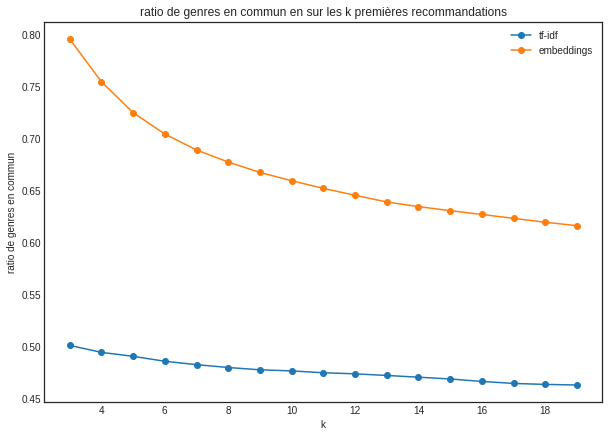

In [66]:
plt.figure(figsize=(10,7))
plt.plot(range(3, 20, 1), kmesures, marker="o", label="tf-idf")
plt.plot(range(3, 20, 1), kmesuresembedding, marker="o", label="embeddings")
plt.xlabel("k")
plt.ylabel("ratio de genres en commun")
plt.title("ratio de genres en commun en sur les k premières recommandations")
plt.legend()
plt.show()

## Similarités entre séries par word2vec

#### utilisation de word embeddings avec tf-idf pour trouver une mesure de similarité entre les différentes séries

### Principe

Pour le calcul de similarité entre les documents, nous allons suivre la même méthode qu'avant :
- représenter un document par un vecteur
- utiliser des mesures de distance pour calculer la similarité entre deux vecteurs ( deux documents )

Ceci servira comme base pour faire un clustering de "genre" ou de "style" des documents.
Nous allons pour un début tester juste une combinaison de possibilités:
- démarrer à partir des vecteurs tf-idf des documents
- vecteurs word embedding généré par Word2vec
- distance de mesure : cosinus

### Word embedding ? 

Un word embedding est une façon de représenter les mots par des vecteurs d'une taille définie, ${p}$ ici. Ces embeddings, ou vecteurs, nous donnent une représentation du contexte des mots.

Pour générer ces vecteurs nous allons utiliser Word2Vec entrainé sur le corpus entier, c'est à dire un gros fichier text qui contient l'ensemble des mots de tout le corpus.

Pour cela nous allons utiliser un simple principe:
- Soit ${V}$ le vecteur de taille ${N}$ représentant un document (N = nombre de mots du vocabulaire ) 
- Soit ${p}$ la taille fixe du vecteur word embedding
- Soit la matrice ${M}$ de dimension ${N \times p}$, où chaque ligne ${i} est le vecteur word embedding obtenu à partir de word2vec correspondant au i-ème mot du vocabulaire

Le vecteur ${D}$ représentant le document embedding sera donc simplement :  ${D = V\cdot M}$ soit un vecteur de taille ${p}$ pour représenter un document.


### Librarie personelle

Nous avons créé une classe qui permet de générer des matrices de similarités pour nos séries en suivant les étapes suivantes :
- Import de notre classe **CustomSim** du fichier **CustomSimilarity.py**
- Spécifier les différents paramètres de word2vec (nombre de séries, taille du vecteur embedding, fenêtre de mots considérés...)
- Spécifier un Tokenizer (Suppression de stop words uniquement, stemming, lemming..)
- Spécifier un Vectorizer (Bag of words, Tf-idf...)
- Spécifier un Combiner, c'est à dire la manière de combiner les informations que l'on a pour obtenir un embedding d'une série
- Spécifier la mesure de similarité (Cosine...)

La classe est optimisée de telle sorte que l'on puisse éviter de refaire des calculs déja fait, tous les calculs intermédiaires sont stockés dans des fichiers.

## Dans notre cas

Nous avons utilisé :
- Suppression de stop words seulement
- Tf-idf
- Somme des embeddings des mots d'une série pondérés par leurs tf-idf
- Mesure de similarité Cosinus

In [13]:
nbSeries = 3000
seriesNames, _ = getMostImportantSeries(path, byepisodes=True)
series = seriesNames[:nbSeries]
print("{} séries.".format(len(series)))

3000 séries.


#### Ouverture de la matrice calculé préalablement

- nombre de séries: 3000
- vec_size: 200
- word_window: 8
- word_count_min: 5
- vectorizer: td-idf
- méthode pour combiner les vecteurs: somme pondérée tf-idf
- mesure de similarité: cosinus

In [4]:
sim = np.load("similarity_matrices/sim_15_.npy")

In [19]:
krecommendations(sim, series, '2956_Criminal_Minds', 5)
krecommendations(sim, series, '1474_The_Batman', 5)
krecommendations(sim, series, '2469_The_Simpsons', 5)
krecommendations(sim, series, '3259_Stargate_SG-1', 5)
krecommendations(sim, series, '1910_NCIS', 5)

series les plus proches de Criminal Minds:
   Criminal Minds
   Criminal Minds  Suspect Behavior
   Profiler
   Millennium
   Cracked
series les plus proches de The Batman:
   The Batman
   Batman  The Brave and the Bold
   Batman
   The Spectacular Spider-Man
   Teen Titans
series les plus proches de The Simpsons:
   The Simpsons
   American Dad
   The Cleveland Show
   The Looney Tunes Show (2011)
   Man Up
series les plus proches de Stargate SG-1:
   Stargate SG-1
   Star Trek  Deep Space Nine
   Crusade
   Earth  Final Conflict
   Babylon 5
series les plus proches de NCIS:
   NCIS
   NCIS  New Orleans
   NCIS  Los Angeles
   Person of Interest
   Castle


Nous remarquons que les séries les plus similaires ont l'air d'être très très proches intuitivement

### Considérons les séries avec notes

Construisons la liste des séries pértinentes pour chaque série

In [40]:
def buildSimilaires(series, series_df, skippable, sim, until):
    everything = series_df[["seriesname","genres"]].values
    similaires = []
    assez = True
    count = 0
    for j , nom in enumerate(everything[:,0]):
        if j in skippable:
            continue
        ch = nom

        s = series.index(ch)

        mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:until]
        l = []
        for a, b in mdr:
            df = series_df[series_df["seriesname"]==a]
            if df.empty:
                continue
            l.append(a)
        if len(l) == 0:
            print("La serie ",nom," n'a pas de similaires dans les ",until," premieres series de la matrice inter series_df")
        if len(l) < 50:
            print("La serie ",nom," n'a que ",len(l)," similaires")
            count+=1
            assez = False
        similaires.append(l)

    return similaires

similaires = buildSimilaires(series, series_df, skippable, sim, 450)
#450 car sa permet d'avoir toutes les séries evaluable à k=50 sauf une seule

La serie  1640_Great_British_Railway_Journeys  n'a que  36  similaires


A partir de la matrice de similarités, nous calculons quels sont les séries qui sont les plus similaires à la série choisie

On supprime les séries non trouvables parmis celles notés

### Evaluation des résultats

In [42]:
evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similaires, pertinent, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

precision: 0.872
rappel: 0.031
F1: 0.037


Surprise ! Les performances du système sont considérablement meilleures qu'en utilisant tout simplement Bag of words ou bien Tf-idf.

La combinaison entre word2vec et Tf-idf améliore donc notre modèle de similarités.

###  Tests avec stemming, lemmatizing 

Testons les performances avec d'autres prétraitements

En **1**:
- nombre de séries: 3000
- vec_size: 200
- word_window: 8
- word_count_min: 5
- tokenizer: stemming
- vectorizer = tfidf
- méthode pour combiner les vecteurs: somme pondérée tf idf
- mesure de similarité: cosinus

En **2**:

pareil mais tokenizer = lemming

In [43]:
simStem = np.load("similarity_matrices/sim_13_.npy")
simLem = np.load("similarity_matrices/sim_14_.npy")

In [44]:
similairesStem = buildSimilaires(series, series_df, skippable, simStem, 450)
similairesLem = buildSimilaires(series, series_df, skippable, simLem, 450)

La serie  1640_Great_British_Railway_Journeys  n'a que  44  similaires
La serie  1640_Great_British_Railway_Journeys  n'a que  38  similaires


In [45]:
evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similairesStem, pertinent, k=10)

print("Evaluation avec Stemming")
print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similairesLem, pertinent, k=10)

print("Evaluation avec lemmatizing")
print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

Evaluation avec Stemming
precision: 0.868
rappel: 0.030
F1: 0.037
Evaluation avec lemmatizing
precision: 0.872
rappel: 0.031
F1: 0.037


### Remarque : 
Bizarrement le stemming donne des performances moins bonnes que aucun traitement, et la lemmatization donne le meme resultat que sans traitement.

Mais cela n'empèche pas que les résultats soient meilleurs qualitativement, vu que la mesure de performance n'est que le genre des séries. Si le stemming propose Grey's Anatomy pour House, cela reste meilleur qualitativement qu'une autre série qui est exactement du même genre que House mais qui d'un point de vue subjectif ne lui ressemble pas vraiment. Notre mesure qualitative reste "bricolée".

## Comparaison des évaluations à k

In [54]:
simTFIDF = similairesTFIDF
simBOW = similairesBOW
simEMB_Simple = similaires
simEMB_Stem = similairesStem
simEMB_Lem = similairesLem

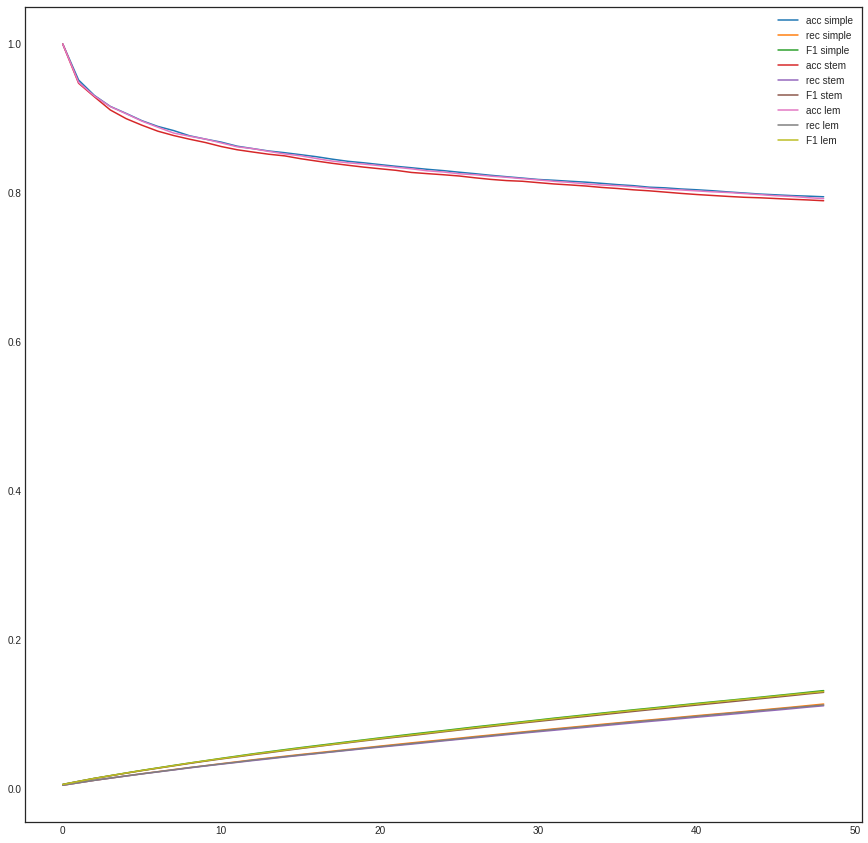

Liste ou on montre à chaque K, la meilleure précision appartient à qui
['Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple', 'Simple']


In [61]:
psEmb_Simple = []
rsEmb_Simple = []
fsEmb_Simple = []

psEmb_Stem = []
rsEmb_Stem = []
fsEmb_Stem = []

psEmb_Lem = []
rsEmb_Lem = []
fsEmb_Lem = []

best = []

for i in range(1,50):
    evaluation = EvalIRmodel()
    evaluations = evaluation.evaluate(simEMB_Simple, pertinent, k=i)

    simple = evaluations["precision"]["mean"]
    psEmb_Simple.append(evaluations["precision"]["mean"])
    rsEmb_Simple.append(evaluations["recall"]["mean"])
    fsEmb_Simple.append(evaluations["F1"]["mean"])
    
    evaluation = EvalIRmodel()
    evaluations = evaluation.evaluate(simEMB_Stem, pertinent, k=i)

    stem = evaluations["precision"]["mean"]
    psEmb_Stem.append(evaluations["precision"]["mean"])
    rsEmb_Stem.append(evaluations["recall"]["mean"])
    fsEmb_Stem.append(evaluations["F1"]["mean"])
    
    evaluation = EvalIRmodel()
    evaluations = evaluation.evaluate(simEMB_Lem, pertinent, k=i)

    lem = evaluations["precision"]["mean"]
    psEmb_Lem.append(evaluations["precision"]["mean"])
    rsEmb_Lem.append(evaluations["recall"]["mean"])
    fsEmb_Lem.append(evaluations["F1"]["mean"])
    
    if lem > stem and lem > simple:
        best.append("Lem")
    if stem > simple and stem > lem:
        best.append("Stem")
    if simple > lem and simple > stem:
        best.append("Simple")
    
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))

plt.plot(psEmb_Simple, label="acc simple")
plt.plot(rsEmb_Simple, label="rec simple")
plt.plot(fsEmb_Simple, label="F1 simple")

plt.plot(psEmb_Stem, label="acc stem")
plt.plot(rsEmb_Stem, label="rec stem")
plt.plot(fsEmb_Stem, label="F1 stem")

plt.plot(psEmb_Lem, label="acc lem")
plt.plot(rsEmb_Lem, label="rec lem")
plt.plot(fsEmb_Lem, label="F1 lem")

plt.legend()
plt.show()

print("Liste ou on montre à chaque K, la meilleure précision appartient à qui")
print(best)

On arrive à voir que la lemmatization a presque exactement les memes performances que sans traitement, mais on voit bien que simple sans traitement a la meilleure précision pour tout K

### Résultats comparé à BOW et TF-IDF

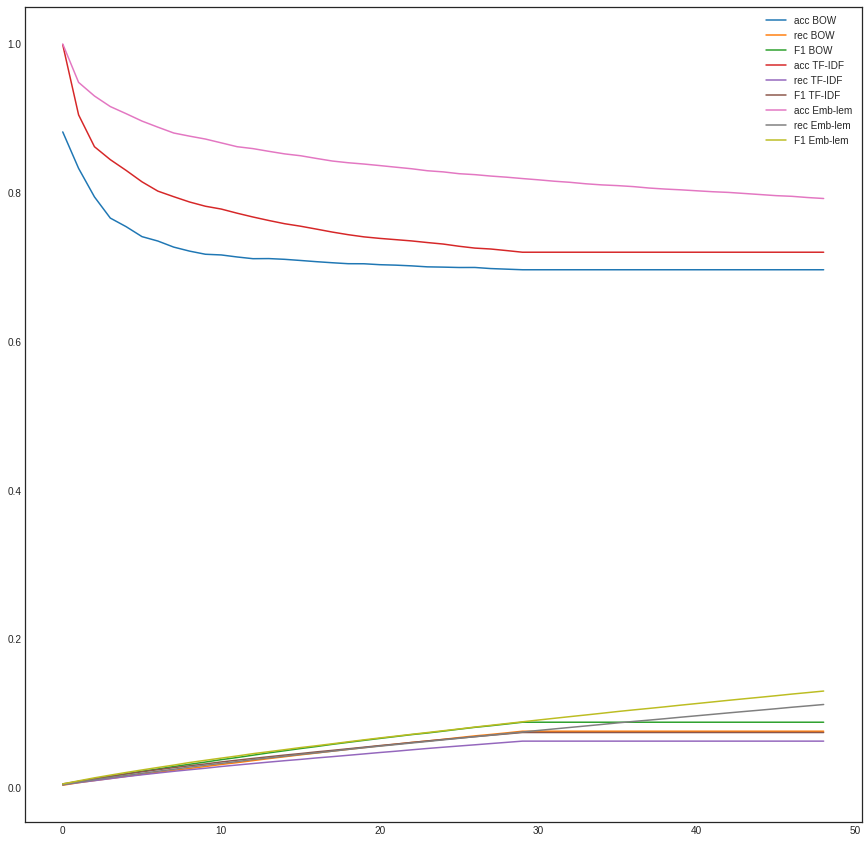

In [62]:
psBOW = []
rsBOW = []
fsBOW = []

psTF_IDF = []
rsTF_IDF = []
fsTF_IDF = []

best = []

for i in range(1,50):
    evaluation = EvalIRmodel()
    evaluations = evaluation.evaluate(simBOW, pertinent, k=i)

    simple = evaluations["precision"]["mean"]
    psBOW.append(evaluations["precision"]["mean"])
    rsBOW.append(evaluations["recall"]["mean"])
    fsBOW.append(evaluations["F1"]["mean"])
    
    evaluation = EvalIRmodel()
    evaluations = evaluation.evaluate(simTFIDF, pertinent, k=i)

    stem = evaluations["precision"]["mean"]
    psTF_IDF.append(evaluations["precision"]["mean"])
    rsTF_IDF.append(evaluations["recall"]["mean"])
    fsTF_IDF.append(evaluations["F1"]["mean"])
    
    
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))

plt.plot(psBOW, label="acc BOW")
plt.plot(rsBOW, label="rec BOW")
plt.plot(fsBOW, label="F1 BOW")

plt.plot(psTF_IDF, label="acc TF-IDF")
plt.plot(rsTF_IDF, label="rec TF-IDF")
plt.plot(fsTF_IDF, label="F1 TF-IDF")

plt.plot(psEmb_Lem, label="acc Emb-lem")
plt.plot(rsEmb_Lem, label="rec Emb-lem")
plt.plot(fsEmb_Lem, label="F1 Emb-lem")

plt.legend()
plt.show()

# Conclusion

Clairement les performances de la méthode utilisant les embeddings sont bien meilleures que BOW ou TF-IDF selon nos mesures de qualité, perfectibles il est vrai.

Nous allons donc utiliser ultérieurement soit la version Embeddings lemmatisé ou la version Embeddings Simple.

Les matrices de similarité sont maintenant enregistrées sur le disque, il ne reste plus qu'à les utiliser dans la suite du projet. C'est parti!